In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

### Load the image training and validation datasets

#### i. Get the image Datasets paths

In [2]:
#train_dataset_path = r'C:\Users\Shailesh\Documents\NEw Folder\DL\Practice\CNN'


#### ii. Load image datasets and apply agumentations

Since the images present in the datasets are 150x150px in size, the image height and width are taken as 150, 150 respectively. The batch size value can be changed if required

In [3]:
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 32

   Loading the training datasets and applying agumentations on it

In [4]:
train_datagen = ImageDataGenerator(rescale = 1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory("C:/Users/Shailesh/Documents/NEw Folder/DL/Practice/CNN/seg_train",
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 12166 images belonging to 6 classes.


In [5]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory("C:/Users/Shailesh/Documents/NEw Folder/DL/Practice/CNN/seg_test/",
                                                             target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 3000 images belonging to 6 classes.


### iii. Get the Label Mappings

The labels dictionary is made in order to retrive the class names against the label indices used for training the model

In [6]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print('Label mappings for classes present in the training and validation datasets\n')
for key, value in labels.items():
    print(f"{key} : {value}")

Label mappings for classes present in the training and validation datasets

0 : buildings
1 : forest
2 : glacier
3 : mountain
4 : sea
5 : street


### 3. Plotting Sample Training samples

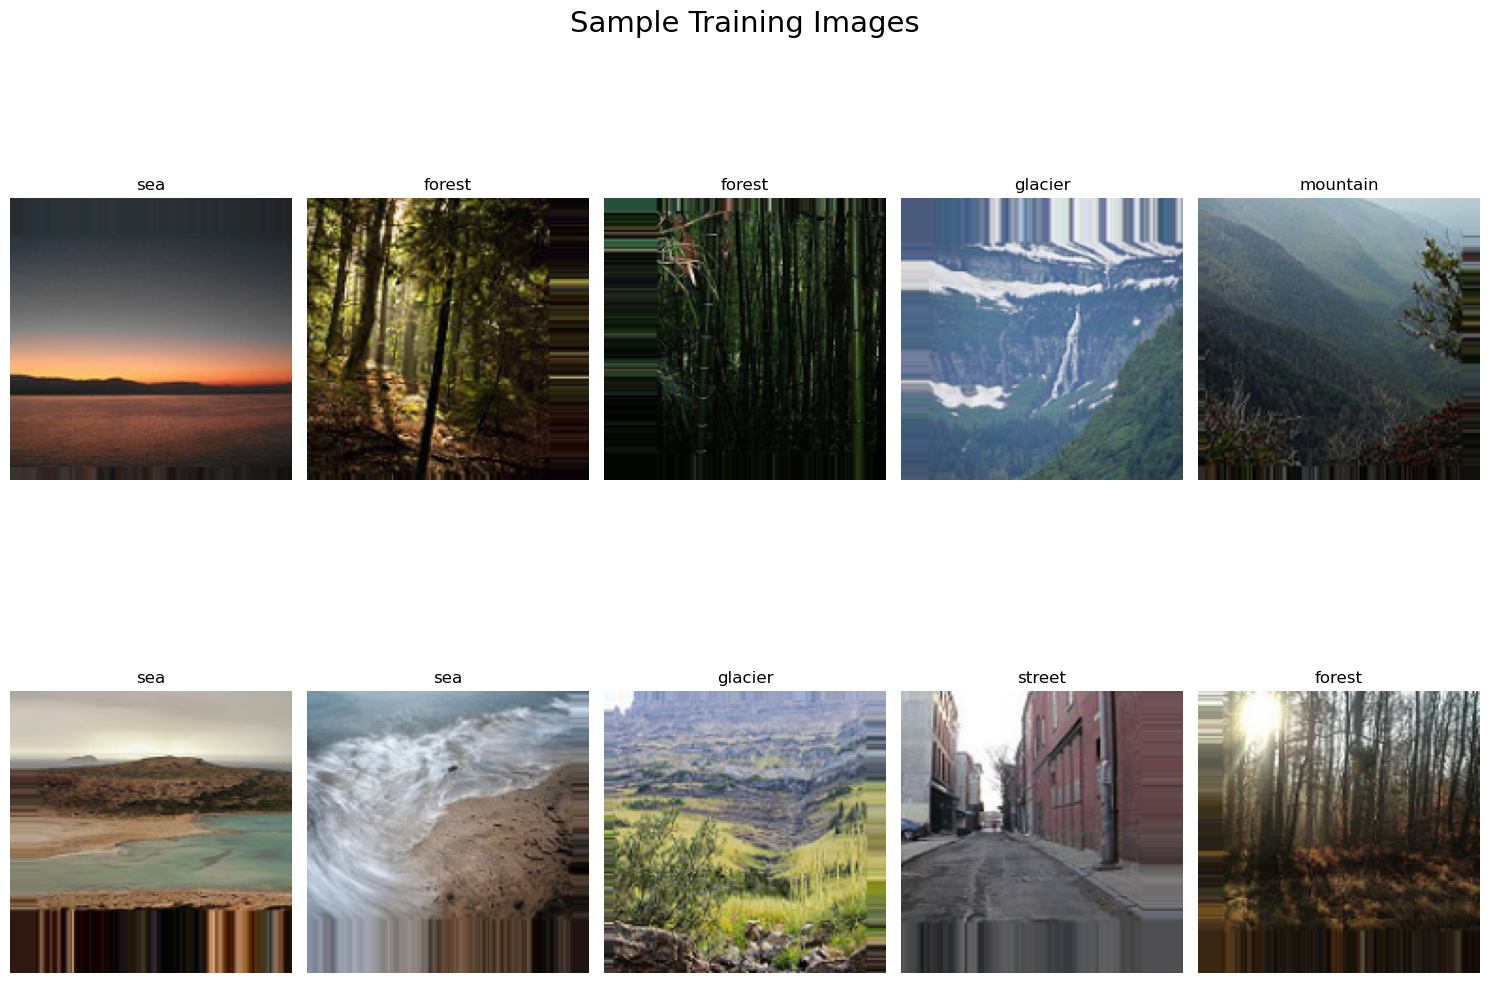

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15,12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1
        
plt.tight_layout()
plt.suptitle('Sample Training Images', fontsize=21)
plt.show()

### 4. Training a CNN Model

Since the training dataset is ready let's create a simple CNN model to train on the image datasets

#### i. Create a CNN Model

In [8]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', 
               input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'), MaxPooling2D(), BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', 
               kernel_regularizer=l2(0.00005)),
        Activation('relu'), MaxPooling2D(), BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3,3), padding='valid', 
               kernel_regularizer=l2(0.00005)),
        Activation('relu'), MaxPooling2D(), BatchNormalization(),
        
        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=6, activation='softmax')
        
    ])
    return model

In [9]:
cnn_model = create_model()

In [10]:
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 128)     9728      
                                                                 
 activation (Activation)     (None, 146, 146, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 73, 73, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 71, 71, 64)        73792     
                                                                 
 activation_1 (Activation)   (None, 71, 71, 64)        0

#### ii. Defining Callbacks


In [11]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [12]:
# optimizer
optimizer = Adam(learning_rate=0.001)

In [13]:
# compile
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [14]:
history = cnn_model.fit(train_generator, epochs=25, 
                        validation_data=validation_generator, 
                        verbose=2, callbacks=[reduce_lr])


Epoch 1/25
381/381 - 729s - loss: 2.0037 - accuracy: 0.5356 - val_loss: 1.6344 - val_accuracy: 0.4860 - lr: 0.0010 - 729s/epoch - 2s/step
Epoch 2/25
381/381 - 694s - loss: 1.0704 - accuracy: 0.6321 - val_loss: 1.0086 - val_accuracy: 0.6327 - lr: 0.0010 - 694s/epoch - 2s/step
Epoch 3/25
381/381 - 692s - loss: 0.8979 - accuracy: 0.6840 - val_loss: 0.9911 - val_accuracy: 0.6360 - lr: 0.0010 - 692s/epoch - 2s/step
Epoch 4/25
381/381 - 688s - loss: 0.8155 - accuracy: 0.7104 - val_loss: 1.0856 - val_accuracy: 0.6177 - lr: 0.0010 - 688s/epoch - 2s/step
Epoch 5/25
381/381 - 690s - loss: 0.7779 - accuracy: 0.7305 - val_loss: 5.3402 - val_accuracy: 0.2047 - lr: 0.0010 - 690s/epoch - 2s/step
Epoch 6/25
381/381 - 755s - loss: 0.7084 - accuracy: 0.7519 - val_loss: 0.7866 - val_accuracy: 0.7083 - lr: 0.0010 - 755s/epoch - 2s/step
Epoch 7/25
381/381 - 724s - loss: 0.6896 - accuracy: 0.7564 - val_loss: 1.0795 - val_accuracy: 0.6067 - lr: 0.0010 - 724s/epoch - 2s/step
Epoch 8/25
381/381 - 695s - loss: 

### Plotting the Model Metrics

#### Plotting training and validation accuracy, loss and learning rate

In [15]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

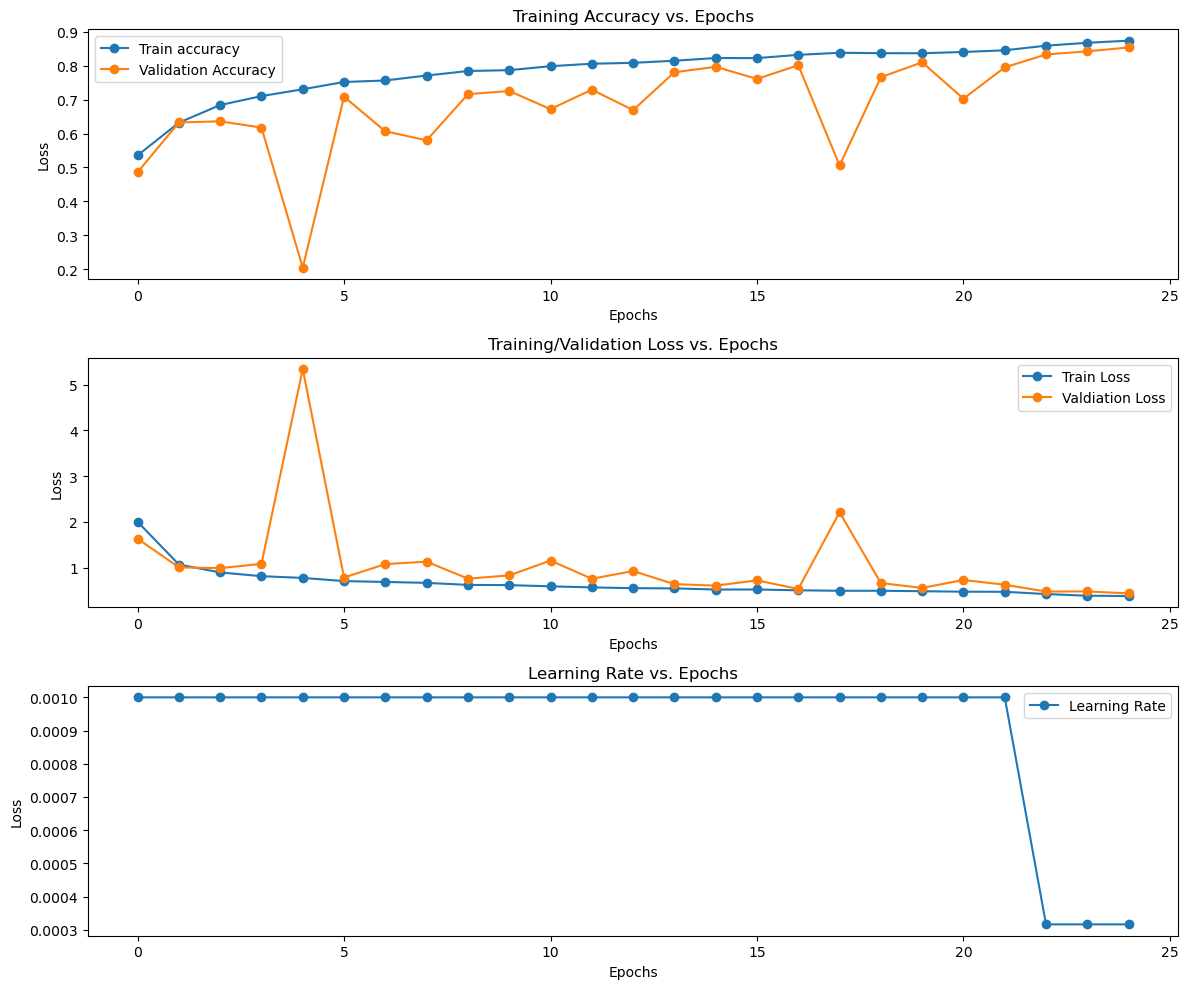

In [17]:
fig,ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label = 'Train accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Valdiation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

###  Testing the Model on Test Set
Testing the model on the validation dataset.

In [37]:
test_dataset = "C:/Users/Shailesh/Documents/NEw Folder/DL/Practice/CNN/seg_test/"

In [19]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory("C:/Users/Shailesh/Documents/NEw Folder/DL/Practice/CNN/seg_test/",
                                                  target_size= (IMG_WIDTH, IMG_HEIGHT),
                                                  batch_size= BATCH_SIZE,
                                                  shuffle=False,
                                                  class_mode = 'categorical'
                                                  )

Found 3000 images belonging to 6 classes.


### Model Prediction on the Test Dataset 

In [21]:
predictions = cnn_model.predict(test_generator)

94/94 [==============================] - 38s 406ms/step


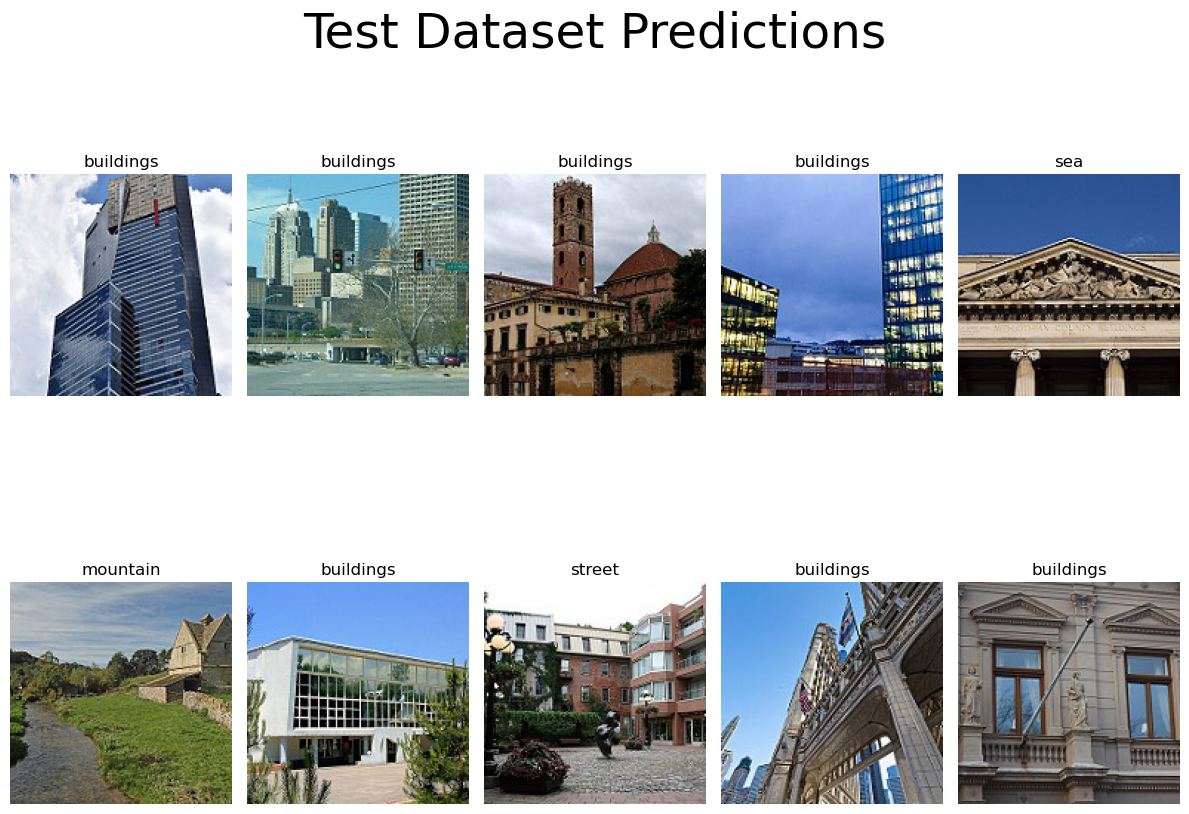

In [24]:
fig,ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis('off')
        idx += 1
        
plt.tight_layout()
plt.suptitle('Test Dataset Predictions', fontsize=35)
plt.show()

In [25]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator, batch_size=BATCH_SIZE)

94/94 [==============================] - 35s 371ms/step - loss: 0.4398 - accuracy: 0.8537


In [28]:
print(f"Test loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test loss: 0.43980154395103455
Test Accuracy: 0.8536666631698608


### Plotting the Classification Metrics

#### Confusion Matrix

In [30]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

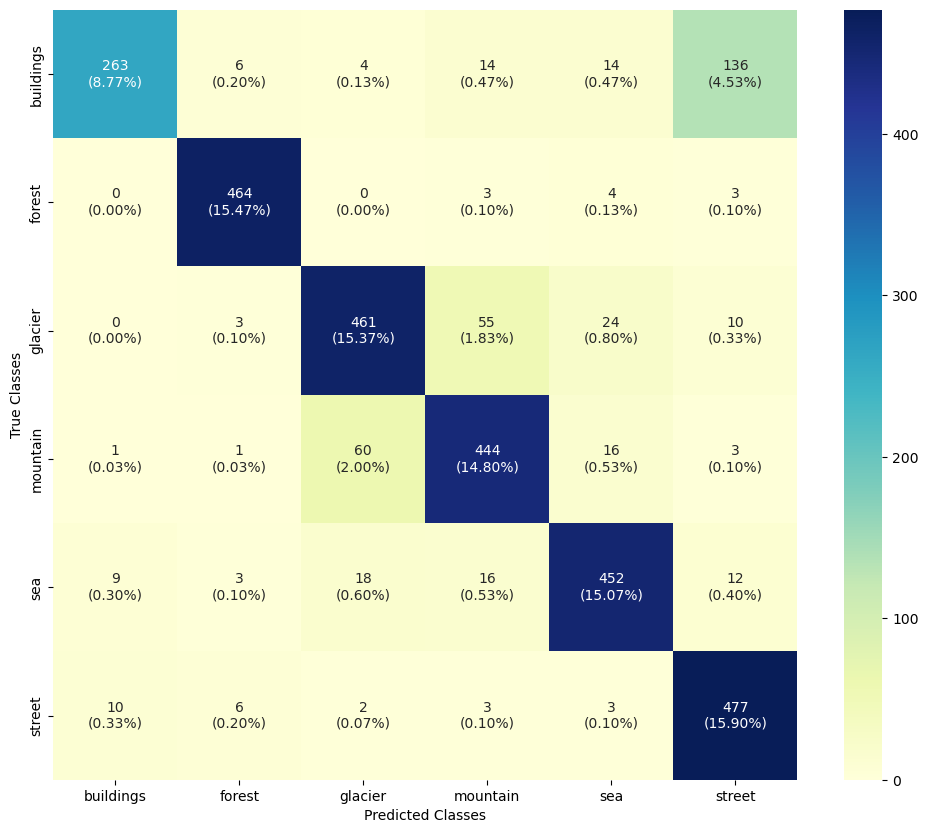

In [32]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in 
                     cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(6,6)

plt.figure(figsize=(12,10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), 
           yticklabels=labels.values(), 
           cmap='YlGnBu', fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [33]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

   buildings       0.93      0.60      0.73       437
      forest       0.96      0.98      0.97       474
     glacier       0.85      0.83      0.84       553
    mountain       0.83      0.85      0.84       525
         sea       0.88      0.89      0.88       510
      street       0.74      0.95      0.84       501

    accuracy                           0.85      3000
   macro avg       0.87      0.85      0.85      3000
weighted avg       0.86      0.85      0.85      3000



### Wrong Predictions
Let's see where the model has given wrong predictions and what were the actual predictions on those images.

In [34]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [35]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

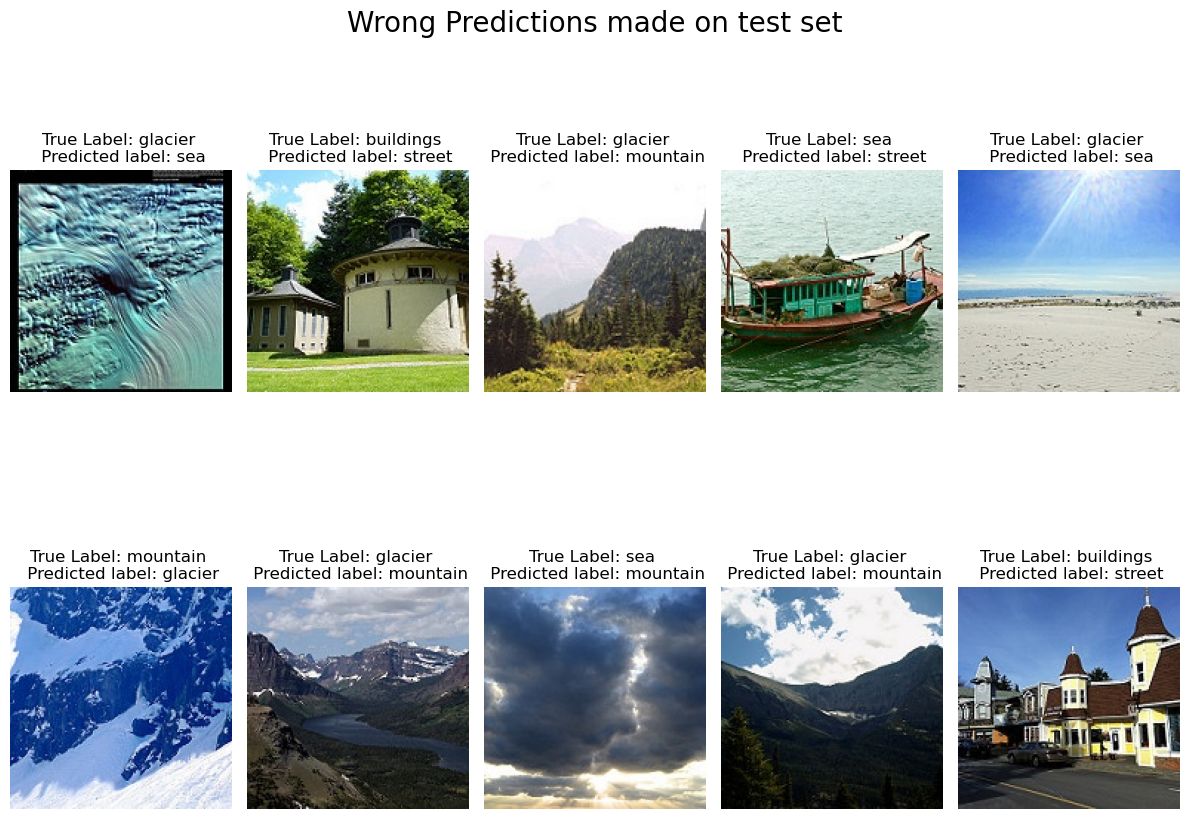

In [40]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12,10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted label: {predicted_label}")
        img_path = os.path.join(test_dataset, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis('off')
        
plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()